In [1]:
%matplotlib inline
import csv
import urllib.request
import codecs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action="ignore")

In [2]:
df = pd.read_csv('AFSNT.csv', encoding="cp949")
df.head()

,SDT_YY,SDT_MM,SDT_DD,SDT_DY,ARP,ODP,FLO,FLT,REG,AOD,IRR,STT,ATT,DLY,DRR,CNL,CNR
0,2017,1,1,일,ARP3,ARP6,J,J1955,SEw3NzE4,D,N,10:05,10:32,N,NaN,N,NaN
1,2017,1,1,일,ARP3,ARP6,J,J1954,SEw3NzE4,A,N,9:30,9:31,N,NaN,N,NaN
2,2017,1,1,일,ARP3,ARP6,J,J1956,SEw3NzE4,A,N,12:45,13:03,N,NaN,N,NaN
3,2017,1,1,일,ARP3,ARP6,J,J1957,SEw3NzE4,D,N,13:25,14:09,Y,C02,N,NaN
4,2017,1,1,일,ARP3,ARP6,J,J1958,SEw3NzE4,A,N,16:10,16:31,N,NaN,N,NaN


In [3]:
df=df[df["CNL"]!="Y"]
# 비행기 취소와 관련된 Column 삭제
df.drop(columns=['CNL', 'CNR'], axis=1, inplace=True)

# 사용되지 않을 것 같은 데이터 일단 삭제
df.drop(columns=['REG', 'IRR'], axis=1, inplace=True)
    
# ATT (actual time data)가 널 값인 레코드 삭제
df = df[pd.notnull(df['ATT'])]

df.rename(columns={'SDT_YY':'Year', 'SDT_MM':'Month', 'SDT_DD':'DAY'}, inplace=True)


In [4]:
from datetime import datetime, date

df['Diff'] = (pd.to_datetime(df['ATT'],format= '%H:%M') - pd.to_datetime(df['STT'],format= '%H:%M')).dt.seconds.astype('int64')

# STT와 ATT 격차 큰 순대로 정렬
df = df.sort_values(by=['Diff'], ascending=False)

########################################################################출발
# 딜레이가 최대 5시간이라고 가정했을 때, --> 즉, 2시간 초과한 딜레이는 wrong값이라 가정
max_delay_hour = 5
max_delay = max_delay_hour * 3600 # seconds

# 출발비행기의 경우, 조금이라도 출발이 빠른 건 wrong data라 판단.
# 7200보다 큰 값을 가지는 Diff 데이터 wrong 값 처리
df = df[((df['Diff'] <= max_delay) & (df['AOD']=='D')) | (df['AOD']=='A')]

df.head(100)

########################################################################도착
#이정도는 늦게 도착해도 O
#2시간은 예상보다 늦게도착할 수 있다. 그 이상은 말이안된다
max_delay_hour_arr = 5
max_delay_arr = max_delay_hour_arr * 3600 # seconds

#몇분 일찍도착해도 O
#30분은 예상보다 빨리도착할 수 있음. 그거보다 빨리도착하는 건 말이 안됨
min_delay = 30*60
min_delay = 86400 - min_delay  # 86400(24시간)보다 위인거만 살려놓기
df = df[(df['AOD']=='D') |((df['Diff'] <= max_delay_arr) & (df['AOD']=='A')) | ((df['AOD']=='A')& (df['Diff'] >= min_delay )) ]
df.loc[df['Diff'] >=min_delay, 'Diff'] = df.loc[df['Diff'] >=min_delay, 'Diff']  - 86400
df.head(100)

,Year,Month,DAY,SDT_DY,ARP,ODP,FLO,FLT,AOD,STT,ATT,DLY,DRR,Diff
352539,2017,9,16,토,ARP3,ARP6,I,I1559,A,20:25,20:24,N,NaN,-60
311690,2017,10,2,월,ARP3,ARP6,H,H1875,A,18:40,18:39,N,NaN,-60
840590,2019,6,7,금,ARP3,ARP14,J,J1854,A,14:30,14:29,N,NaN,-60
194703,2017,11,1,수,ARP3,ARP2,F,F1905,A,8:35,8:34,N,NaN,-60
668110,2018,12,28,금,ARP1,ARP8,A,A1704,A,11:50,11:49,N,NaN,-60
16642,2017,2,25,토,ARP3,ARP1,J,J1216,A,11:05,11:04,N,NaN,-60
368752,2017,2,25,토,ARP1,ARP3,L,L1764,A,13:40,13:39,N,NaN,-60
568327,2018,2,16,금,ARP3,ARP1,F,F1257,A,14:00,13:59,N,NaN,-60
134515,2017,6,17,토,ARP2,ARP3,B,B1134,A,20:00,19:59,N,NaN,-60
487408,2018,10,22,월,ARP1,ARP12,J,J1637,A,21:05,21:04,N,NaN,-60


In [5]:
# 시간에서 시 데이터만 추출 ==> 분은 영향을 줄임.
df['ATT'] = pd.to_datetime(df['ATT'],format= '%H:%M').dt.hour
df['STT'] = pd.to_datetime(df['STT'],format= '%H:%M').dt.hour

In [6]:
# ARP와 ODP가 같은 데이터 --> Wrong data => 삭제
wi = df[df['ARP'] == df['ODP']].index
df.drop(wi, inplace=True)

# ARP 경로 파생변수 생성
df['ARPODP'] = df['ARP'] + '_' + df['ODP']

############ 잠시 삭제
# 일단 FLT는 처리할 방법이 없어서 삭제해놓음
df.drop(['FLT'], axis=1, inplace = True)

In [7]:
#요일 카테고리컬
one_hot_dy = pd.get_dummies(df['SDT_DY'])
df = df.drop(['SDT_DY'],axis = 1)
df = df.join(one_hot_dy)
df.rename(columns={"일":"Sun","월":"Mon","화":"Tue","수":"Wed","목":"Thu","금":"Fri","토":"SAT","일":"Sun"                    
                  }, inplace=True)

In [8]:
df.drop(['ATT','Diff'], axis = 1, inplace=True)
df.drop(columns=['DRR'], axis=1, inplace=True)

In [9]:

# Check the numerical data
numerical_feature = [col for col in df.columns if df[col].dtypes == 'int64']
print(numerical_feature)

def dist_box(df, feature_list):
    for col in feature_list:
        plt.figure(figsize=(15, 5))
        sns.distplot(df.loc[df[col].notnull(), col])
        plt.title(col)
        plt.show()
        
        df[col].plot(kind='box', color='red')
        plt.show()

"""
print('*'*50)
print('All')
dist_box(df, numerical_feature)
print('*'*50)
print('Arrive')
dist_box(df[df['AOD'] == 'A'], numerical_feature)
print('*'*50)
print('Departure')
dist_box(df[df['AOD'] == 'D'], numerical_feature)
"""

['Year', 'Month', 'DAY', 'STT']


"\nprint('*'*50)\nprint('All')\ndist_box(df, numerical_feature)\nprint('*'*50)\nprint('Arrive')\ndist_box(df[df['AOD'] == 'A'], numerical_feature)\nprint('*'*50)\nprint('Departure')\ndist_box(df[df['AOD'] == 'D'], numerical_feature)\n"

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 976899 entries, 352539 to 716355
Data columns (total 17 columns):
Year      976899 non-null int64
Month     976899 non-null int64
DAY       976899 non-null int64
ARP       976899 non-null object
ODP       976899 non-null object
FLO       976899 non-null object
AOD       976899 non-null object
STT       976899 non-null int64
DLY       976899 non-null object
ARPODP    976899 non-null object
Fri       976899 non-null uint8
Thu       976899 non-null uint8
Wed       976899 non-null uint8
Mon       976899 non-null uint8
Sun       976899 non-null uint8
SAT       976899 non-null uint8
Tue       976899 non-null uint8
dtypes: int64(4), object(6), uint8(7)
memory usage: 88.5+ MB


In [11]:
# 1일 이라고 되어있는 데이터를 합칠떄 01로 변환
def changeDate(data):
    data=str(data)
    if len(data)==1:
        data="0"+data
    return data

In [12]:
#군공항 제외날씨 데이터 다운(항공데이터)

def downloadAirport(yy,mm,area):
    mm=changeDate(mm)
    yy=str(yy)
    url='http://amoapi.kma.go.kr/amoApi/air_stcs?icao='+area+'&yyyymm='+yy+mm
    response = urllib.request.urlopen(url)
    cr = csv.reader(codecs.iterdecode(response, 'utf-8'))
    
    #url로 읽어와 데이터 프레임에 저장
    temp=[]
    for line in cr:
        temp.append(line)
    
    labels=temp[0]
    weather=pd.DataFrame.from_records(temp[1:],columns=labels)
    
    weather["TM"]=weather["TM"].astype("str")

    weather["Year"]=weather["TM"].str.slice(0,4)
    weather["Month"]=weather["TM"].str.slice(4,6)
    weather["DAY"]=weather["TM"].str.slice(6,8)
    hh=weather["TM"].str.slice(8,10)    

    #weather['DAY'] = pd.to_datetime(weather[['Year', 'Month', 'DAY']])
    weather['STT']=hh
    weather['STT']= weather['STT'].astype('int')
    weather['STT']=weather['STT'].replace(24,0)
    
    
    weather.drop(columns=["TM"], axis=1, inplace=True)
    weather.drop(columns=["WD","WS_GST","RVR1","RVR2","RVR3","RVR4","CLA_1LYR"
               ,"BASE_1LYR","CLF_1LYR","CLA_2LYR","BASE_2LYR","CLF_2LYR",
               "CLA_3LYR","BASE_3LYR","CLF_3LYR","CLA_4LYR","BASE_4LYR","CLF_4LYR"], axis=1, inplace=True)
    
    
    #기록 안되어있는거는 0
    weather=weather.fillna(0)
    weather["Year"]=weather["Year"].astype("int")
    weather["Month"]=weather["Month"].astype("int")
    weather["DAY"]=weather["DAY"].astype("int")
    
    return weather 

In [13]:
#군공항 데이터 저장(기상청 csv)
def downloadWeather(year):
    filename="data/"+str(year)+".csv"
    weather=pd.read_csv(filename,encoding="cp949")
    
    #일시를 데이트타입과 시간을 따로 저장
    weather["일시"] = weather["일시"].astype('str')
    date=weather["일시"].str.split(expand=True)
    day=date[0].str.split("-",expand=True)
    
    weather["Year"]=day[0]
    weather["Month"]=day[1]
    weather["DAY"]=day[2]
    
    
    weather["STT"]=date[1]
    
    #일시 drop(변경 전 데이터)
    weather.drop(columns=['일시'], axis=1, inplace=True)
    weather = weather.drop(['지면온도(°C)',"지면온도 QC플래그","5cm 지중온도(°C)","10cm 지중온도(°C)","20cm 지중온도(°C)","기온 QC플래그",
                            "강수량 QC플래그","풍속 QC플래그","풍향(16방위)","풍향 QC플래그","습도 QC플래그","현지기압 QC플래그",
                            "해면기압 QC플래그","중하층운량(10분위)","운형(운형약어)","최저운고(100m )","지면상태(지면상태코드)",
                           "적설(cm)","3시간신적설(cm)", "30cm 지중온도(°C)","일조(hr)","일조 QC플래그","일사(MJ/m2)"],axis = 1)
    weather.rename(columns={"지점" : "area", "기온(°C)":"temp" ,"강수량(mm)":"rain", "풍속(m/s)":"windSpeed",
                            "습도(%)":"hum","증기압(hPa)":"Vapor","이슬점온도(°C)":"dew","현지기압(hPa)":"hpa",
                            "해면기압(hPa)":"seeHpa","시정(10m)":"visible","전운량(10분위)":"cloudTotal",
                            "현상번호(국내식)":"weatherCode"}, inplace=True)
    weather["STT"]=weather["STT"].astype("str")
    weather["STT"]=weather["STT"].str.split(":",expand=True)[0]
    weather["STT"]=weather["STT"].astype("int")
    
    weather["Year"]=weather["Year"].astype("int")
    weather["Month"]=weather["Month"].astype("int")
    weather["DAY"]=weather["DAY"].astype("int")
    
    weather=weather.fillna(0)
    return weather

In [14]:
weather=downloadAirport(2017,1,"RKSS")
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744 entries, 0 to 743
Data columns (total 14 columns):
WSPD      744 non-null object
VIS       744 non-null object
WC        744 non-null object
TMP       744 non-null object
TD        744 non-null object
PS        744 non-null object
PA        744 non-null object
RN        744 non-null object
HM        744 non-null object
CA_TOT    744 non-null object
Year      744 non-null int32
Month     744 non-null int32
DAY       744 non-null int32
STT       744 non-null int32
dtypes: int32(4), object(10)
memory usage: 69.8+ KB


In [15]:
# 군공항X(공항공사 데이터 돌리기)
def mergeAirportData():
    df_all=pd.DataFrame()
    temp=df[(df.ARP=="ARP1") | (df.ARP=="ARP3")| (df.ARP=="ARP5") | (df.ARP=="ARP7") | (df.ARP=="ARP9")| (df.ARP=="ARP10") ]
    elements,count=np.unique(temp["ARP"],return_counts=True)
    for i in range(len(elements)):
        df_areaD=pd.DataFrame()
        arp=elements[i]
        area={"ARP1":"RKSS","ARP3":"RKPC","ARP5":"RKPU",
              "ARP7":"RKJB","ARP9":"RKJY","ARP10":"RKNY"}.get(arp)
        df_areaD=temp[temp["ARP"]==arp]
        
        for j in range(3):
            year=2017+j
            for k in range(12):
                ## 2019년은 7월데이터 X
                if year==2019:
                    if k>=6:
                        break;
                month=1+k
                df_date=df_areaD[(df_areaD["Year"]==year) & (df_areaD["Month"]==month)]
                weather=downloadAirport(year,month,area)
                df_new=pd.merge(df_areaD,weather,on=["Year","Month","DAY","STT"])
                
                if i==0 and j==0 and k==0:
                    df_all=df_new.copy()
                else:
                    df_all=df_all.append(df_new)
                    
    #기상청데이터와 연결 하기 위해 rename                
    df_all.rename(columns={'WSPD':'windSpeed','VIS':"visible","TMP":"temp",
                      "TD":"dew",'PS':'hpa','PA':'seeHpa','RN':'rain','HM':'hum',
                        'CA_TOT':'cloudTotal','WC':"weatherCode"}, inplace=True)
    
    
    #기상청 데이터와 단위 맞추기
    df_all['temp']=df_all['temp'].astype("float")/10
    df_all['hpa']=df_all['hpa'].astype("float")/10
    df_all['seeHpa']=df_all['seeHpa'].astype("float")/10
    df_all['dew']=df_all['dew'].astype("float")/10
    df_all['windSpeed']=df_all['windSpeed'].astype("float")*1852/3600
    
    return df_all

In [16]:
def mergeWeatherData():
    temp=df[(df.ARP=="ARP2") | (df.ARP=="ARP4")| (df.ARP=="ARP6") | (df.ARP=="ARP8") | (df.ARP=="ARP11")| (df.ARP=="ARP12")
           | (df.ARP=="ARP13")| (df.ARP=="ARP14")|(df.ARP=="ARP15")]
    elements,count=np.unique(temp["ARP"],return_counts=True)
    
    for i in range(3):
        df_areaD=pd.DataFrame()
        year=2017+i
        weather=downloadWeather(year)
        df_yearD=df[df["Year"]==year]
        for j in range(len(elements)):
            arp=elements[j]
            area={"ARP2":159,"ARP4":143,"ARP6":131, "ARP8":156,
                  "ARP11":138,"ARP12":192, "ARP13":140,"ARP14":114,"ARP15":112}.get(arp)
            
            df_areaD=df_yearD[df_yearD["ARP"]==arp]
            df_new=pd.DataFrame()
            weatherT=weather[weather["area"]==area]
           
            df_new=pd.merge(df_areaD,weatherT,on=["DAY","STT","Year","Month"])
        
            if i==0 and j==0:
                df_all=df_new.copy()
            else:
                df_all=df_all.append(df_new)
    return df_all

In [17]:
df_airport=mergeAirportData()
df_nonAirport=mergeWeatherData()

df_weather=df_airport.append(df_nonAirport)

In [18]:
df_weather.drop(['area','Vapor'], axis = 1, inplace=True)

In [20]:
df_weather.to_csv("weatherFinal.csv")

In [21]:
df_weather.head()

,AOD,ARP,ARPODP,DAY,DLY,FLO,Fri,Mon,Month,ODP,...,cloudTotal,dew,hpa,hum,rain,seeHpa,temp,visible,weatherCode,windSpeed
0,A,ARP1,ARP1_ARP3,19,N,A,0,0,1,ARP3,...,3,-10.3,1027.1,77,,1025.4,-6.8,230,10,0.514444
1,A,ARP1,ARP1_ARP2,19,N,H,0,0,1,ARP2,...,3,-10.3,1027.1,77,,1025.4,-6.8,230,10,0.514444
2,D,ARP1,ARP1_ARP3,19,N,F,0,0,1,ARP3,...,3,-10.3,1027.1,77,,1025.4,-6.8,230,10,0.514444
3,D,ARP1,ARP1_ARP3,19,N,L,0,0,1,ARP3,...,3,-10.3,1027.1,77,,1025.4,-6.8,230,10,0.514444
4,D,ARP1,ARP1_ARP3,19,N,I,0,0,1,ARP3,...,3,-10.3,1027.1,77,,1025.4,-6.8,230,10,0.514444


In [22]:
# Categorical data --> one hot encoding

def one_hot_dummies(df, *args):
    for col in args:
        one_hot_col = pd.get_dummies(df[col])
        df = df.drop([col], axis = 1)
        
        try:
            df = df.join(one_hot_col)
        except:
            one_hot_col.rename(columns={'ARP1':'ARP1_','ARP2':'ARP2_','ARP3':'ARP3_','ARP4':'ARP4_','ARP5':'ARP5_',
                                        'ARP14':'ARP14_','ARP12':'ARP12_','ARP10':'ARP10_','ARP8':'ARP8_','ARP6':'ARP6_',
                                        'ARP15':'ARP15_','ARP13':'ARP13_','ARP11':'ARP11_','ARP9':'ARP9_','ARP7':'ARP7_'},
                               inplace=True)
            df = df.join(one_hot_col)
    return df


df = one_hot_dummies(df, 'ARP', 'ODP', 'FLO', 'ARPODP')

In [23]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[['Month', 'STT']] = scaler.fit_transform(df[['Month', 'STT']])

In [24]:
# Target 레이블링

from sklearn import preprocessing
# DLY도 1과 0으로 데이터 처리
le = preprocessing.LabelEncoder()
df[['DLY']] = le.fit_transform(df[['DLY']])

In [25]:
# 도착, 출발 데이터 분리
df_A = df[df['AOD']=='A']
df_D = df[df['AOD']=='D']

# AOD column삭제 
df_A = df_A.drop(['AOD'],axis = 1)
df_D = df_D.drop(['AOD'],axis = 1)

df_A.head(5)

,Year,Month,DAY,STT,DLY,Fri,Thu,Wed,Mon,Sun,...,ARP8_ARP1,ARP8_ARP15,ARP8_ARP2,ARP8_ARP3,ARP8_ARP7,ARP9_ARP1,ARP9_ARP15,ARP9_ARP2,ARP9_ARP3,ARP9_ARP6
352539,2017,0.727273,16,0.869565,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
311690,2017,0.818182,2,0.782609,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
840590,2019,0.454545,7,0.608696,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
194703,2017,0.909091,1,0.347826,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
668110,2018,1.000000,28,0.478261,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score #To evaluate our model
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [27]:
def makeTestSet(df):
    X = df.drop(['DLY'], axis = 1)
    y = df['DLY']
        
    X_tr, X_t, y_tr, y_t = train_test_split(X,y, test_size= 0.3, random_state = 42)
    
    print("X_train set--------------------")
    print("Shape:",X_tr.shape)
    print("Target:")
    print(y_tr.value_counts())
    print()
      
    print("X_test set info-----------------")
    print("Shape:",X_t.shape)
    print("Target:")
    print(y_t.value_counts())
    print()

    return [X_tr, X_t, y_tr, y_t]

X_train_A, X_test_A, y_train_A, y_test_A = makeTestSet(df_A)
X_train_D, X_test_D, y_train_D, y_test_D = makeTestSet(df_D)

X_train set--------------------
Shape: (342400, 136)
Target:
0    319349
1     23051
Name: DLY, dtype: int64

X_test set info-----------------
Shape: (146743, 136)
Target:
0    136884
1      9859
Name: DLY, dtype: int64

X_train set--------------------
Shape: (341429, 136)
Target:
0    281446
1     59983
Name: DLY, dtype: int64

X_test set info-----------------
Shape: (146327, 136)
Target:
0    120510
1     25817
Name: DLY, dtype: int64



In [28]:
# --------------변수 중요도 확인하고 상위 OO개 남기기 -------------------

def feature_importance(X_train, y_train, X_test, y_test):
        
    #### Skew Data처리할거면 주석 해제하기!!
    #X_train, y_train = imbalance(X_train, y_train)
    
    
    log_rg = LogisticRegression().fit(X_train, y_train)
    cross_val_score(log_rg, X_train, y_train, cv=5)
    log_rg.score(X_test, y_test)
    print(classification_report(y_test, log_rg.predict(X_test)))

    # X column 개수 출력
    #print(len(X.columns)) 

    # 변수 중요도 
    fi = pd.DataFrame(zip(X_train.columns.values, abs(log_rg.coef_.ravel())))
    fi.columns = ['feature', 'coef']
    fi.sort_values("coef", ascending=False, inplace=True)
    fi = fi.reset_index().drop(['index'], axis=1)
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
        print(fi)

    for index, val in enumerate(fi.iloc[:, 1]):
        if val < 0.1:
            X_train.drop([fi.iloc[index, 0]], axis = 1, inplace = True)
            X_test.drop([fi.iloc[index, 0]], axis = 1, inplace = True)   
    return

feature_importance(X_train_A, y_train_A, X_test_A, y_test_A)
feature_importance(X_train_D, y_train_D, X_test_D, y_test_D)
print(len(X_train_A.columns))
print(len(X_test_A.columns))
print(len(X_train_D.columns))
print(len(X_test_D.columns))

#--------------------------------------------------------------------

              precision    recall  f1-score   support

           0       0.93      1.00      0.97    136884
           1       0.00      0.00      0.00      9859

    accuracy                           0.93    146743
   macro avg       0.47      0.50      0.48    146743
weighted avg       0.87      0.93      0.90    146743

         feature      coef
0            STT  0.461092
1              J  0.459132
2            Fri  0.264669
3            SAT  0.260565
4          ARP3_  0.240918
5           ARP3  0.189650
6              F  0.176673
7              L  0.170559
8          ARP2_  0.145035
9              I  0.132675
10     ARP3_ARP1  0.131549
11          ARP1  0.130035
12           Mon  0.129677
13           Tue  0.118971
14     ARP2_ARP3  0.106131
15     ARP1_ARP2  0.103715
16           Thu  0.080198
17         Month  0.078295
18          ARP2  0.076312
19         ARP5_  0.074371
20        ARP15_  0.072717
21         ARP1_  0.072653
22         ARP15  0.071061
23          ARP5  0.07103

In [29]:
def imbalance (X_train, y_train):

    # 모델설정
    sm = SMOTE(ratio='auto', kind='regular')

    # train데이터를 넣어 복제함
    X_resampled, y_resampled = sm.fit_sample(X_train,list(y_train))

    print('After OverSampling, the shape of train_X: {}'.format(X_resampled.shape))
    print('After OverSampling, the shape of train_y: {} \n'.format(X_resampled.shape))

    print("After OverSampling, counts of label '1': {}".format(sum(y_resampled==1)))
    print("After OverSampling, counts of label '0': {}".format(sum(y_resampled==0)))
    
    return [X_resampled, y_resampled]

In [30]:
# ROC Curve그리기
def plot_roc_curve(fpr, tpr):
    
    
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [32]:
def confusion_matrix_heatmap(y_true, y_pred):
    data = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

In [33]:
def runModel (X_train, y_train, X_test, y_test, base = True):
    
    #X_train, y_train = underSampling(X_train, y_train)
    
     ## Skew Data처리할거면 주석 풀기!!
    X_train, y_train = imbalance(X_train, y_train)
    
    models = []
    
    if base ==True:
        models.append(('RF', RandomForestClassifier(max_depth=6, n_estimators=1000, random_state=0, criterion='entropy')))
    else:
#         models.append(('LR', LogisticRegression()))
#         models.append(('LDA', LinearDiscriminantAnalysis()))
#         models.append(('KNN', KNeighborsClassifier()))
#         models.append(('CART', DecisionTreeClassifier()))
#         models.append(('NB', GaussianNB()))
        models.append(('RF', RandomForestClassifier(max_depth=4, n_estimators=100, random_state=0)))
#         models.append(('SVM', SVC(gamma='auto')))
#         models.append(('XGB', XGBClassifier()))

    
    # 평가
    results = []
    names = []
    scoring = 'recall'

    seed = 7
    for name, model in models:
        # K-Fold
#         kfold = KFold(n_splits=10, random_state=seed)
#         cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
#         results.append(cv_results)
#         names.append(name)
#         msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
#         print(msg)

        # Hold out 
        model.fit(X_train, y_train)
        y_predict = pd.Series(model.predict(X_test))

        # Resets index to compare original test data with predicted data
        y_test = y_test.reset_index(drop=True)
        y_predict = y_predict.reset_index(drop=True)

#         plt.figure(figsize=(15, 5))
#         plt.scatter(range(y_test.shape[0]), y_test, c='gray')
#         plt.scatter(range(y_predict.shape[0]), y_predict , c='r')
#         diff = abs(y_test - y_predict)
#         plt.bar(range(diff.shape[0]), diff, color='gray')
#         plt.title('Result - Original comparsion')
#         plt.legend(['Original', 'Predict'])
#         plt.show()

        print(model.score(X_test, y_test))
        print('-' * 50)
        
        #--------ROC Curve-----------------
        probs = model.predict_proba(X_test)
        probs = probs[:, 1]
        auc = roc_auc_score(y_test, probs)
        print('AUC: %.2f' % auc)
        
        fpr, tpr, thresholds = roc_curve(y_test, probs)
        plot_roc_curve(fpr, tpr)
        #-----------------------------------
        
        #-------- Confusion matrix heatmap -----------------
        confusion_matrix_heatmap(y_test, y_predict)
        print(classification_report(y_test, y_predict))
        #-----------------------------------
        
             
#      # boxplot algorithm comparison
#     fig = plt.figure(figsize=(11,6))
#     fig.suptitle('Algorithm Comparison')
#     ax = fig.add_subplot(111)
#     plt.boxplot(results)
#     ax.set_xticklabels(names)
#     plt.show()
    
    return

After OverSampling, the shape of train_X: (562892, 18)
After OverSampling, the shape of train_y: (562892, 18) 

After OverSampling, counts of label '1': 281446
After OverSampling, counts of label '0': 281446
0.6075707149056565
--------------------------------------------------
AUC: 0.66


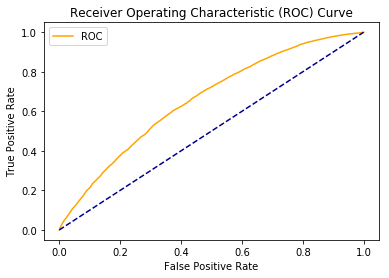

              precision    recall  f1-score   support

           0       0.88      0.60      0.72    120510
           1       0.25      0.62      0.36     25817

    accuracy                           0.61    146327
   macro avg       0.57      0.61      0.54    146327
weighted avg       0.77      0.61      0.65    146327



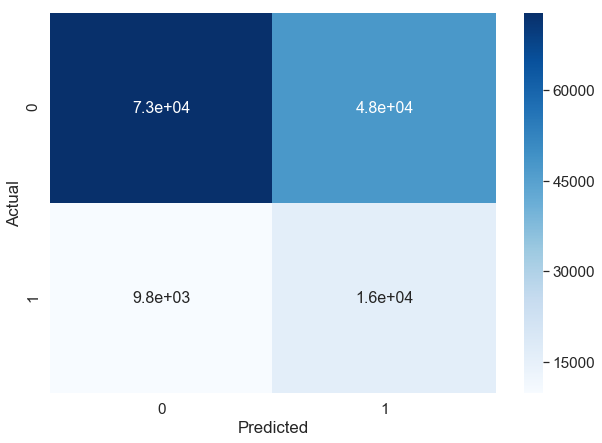

In [34]:
# True면 base algorithm만 실행하겠다 (base algorithm : Random Forest)
# False면 모든 알고리즘을 실행하겠다.
runModel (X_train_D,y_train_D, X_test_D, y_test_D, True)

After OverSampling, the shape of train_X: (638698, 16)
After OverSampling, the shape of train_y: (638698, 16) 

After OverSampling, counts of label '1': 319349
After OverSampling, counts of label '0': 319349
0.5722589833927343
--------------------------------------------------
AUC: 0.64


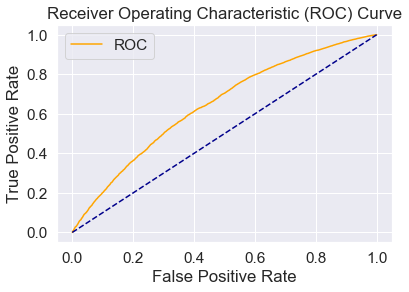

              precision    recall  f1-score   support

           0       0.96      0.57      0.71    136884
           1       0.10      0.64      0.17      9859

    accuracy                           0.57    146743
   macro avg       0.53      0.60      0.44    146743
weighted avg       0.90      0.57      0.68    146743



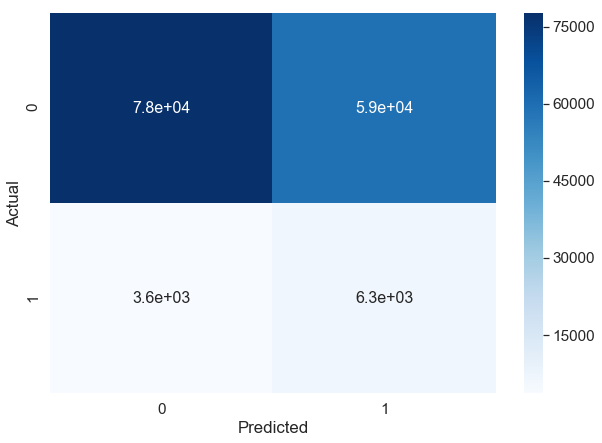

In [35]:
# True면 base algorithm만 실행하겠다 (base algorithm : Random Forest)
# False면 모든 알고리즘을 실행하겠다.
runModel (X_train_A,y_train_A, X_test_A, y_test_A, True)